In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import json


In [ ]:
import importlib
import utils
importlib.reload(utils)
from utils import get_json_file, count_and_visualize_labels


In [ ]:
!ls

data_parameters.json  JobLevelData.csv			__pycache__	    train.py
data_processing.py    mlb_mapping.pkl			requirements.txt    utils.py
drive		      model_training_args.json		sample_data
inference.py	      Multi_label_classification.ipynb	training_args.json


## data analisys

In [ ]:
def get_preprocessed_data(df):
    df['Combined Labels'] = df[['Column 1', 'Column 2', 'Column 3', 'Column 4']].apply(
    lambda row: [x for x in row if pd.notna(x)], axis=1
        )



In [ ]:
general_params= get_json_file('data_parameters.json')

In [ ]:
data_path = general_params['data_path']
df = pd.read_csv(data_path)

In [ ]:
df.shape

(2240, 5)

In [ ]:
df.columns

Index(['Title', 'Column 1', 'Column 2', 'Column 3', 'Column 4'], dtype='object')

In [ ]:
df.describe()

,Title,Column 1,Column 2,Column 3,Column 4
count,2240,2230,133,12,11
unique,2240,6,4,2,1
top,Sales Account Manager Doctor's,Individual Contributor/Staff,Individual Contributor/Staff,Individual Contributor/Staff,Director
freq,1,1039,55,11,11


In [ ]:
df['Combined Labels'] = df[['Column 1', 'Column 2', 'Column 3', 'Column 4']].apply(
    lambda row: [x for x in row if pd.notna(x)], axis=1
)

In [ ]:
# Here, we aim to count the occurrences of each label individually within the 'Combined Labels' column.
# The 'Combined Labels' column is expected to contain lists of labels for each row.
# This provides a summary of how many times each label appears across the dataset.
all_labels = df['Combined Labels'].explode()
all_labels.value_counts()

,count
Combined Labels,
Individual Contributor/Staff,1105
Director,497
Vice President,403
Manager,211
Chief Officer,166
Owner,4


In [ ]:

def get_str_from_label_list(label_list):
    return ', '.join(label_list)

df['String Labels'] = df['Combined Labels'].apply(get_str_from_label_list)

In [ ]:
np.unique(df['String Labels'].values)

array(['', 'Chief Officer', 'Director', 'Director, Chief Officer',
       'Director, Individual Contributor/Staff',
       'Individual Contributor/Staff',
       'Individual Contributor/Staff, Chief Officer', 'Manager',
       'Manager, Chief Officer', 'Manager, Director',
       'Manager, Individual Contributor/Staff', 'Owner',
       'Owner, Chief Officer', 'Vice President',
       'Vice President, Manager', 'Vice President, Manager, Director',
       'Vice President, Manager, Individual Contributor/Staff, Director'],
      dtype=object)

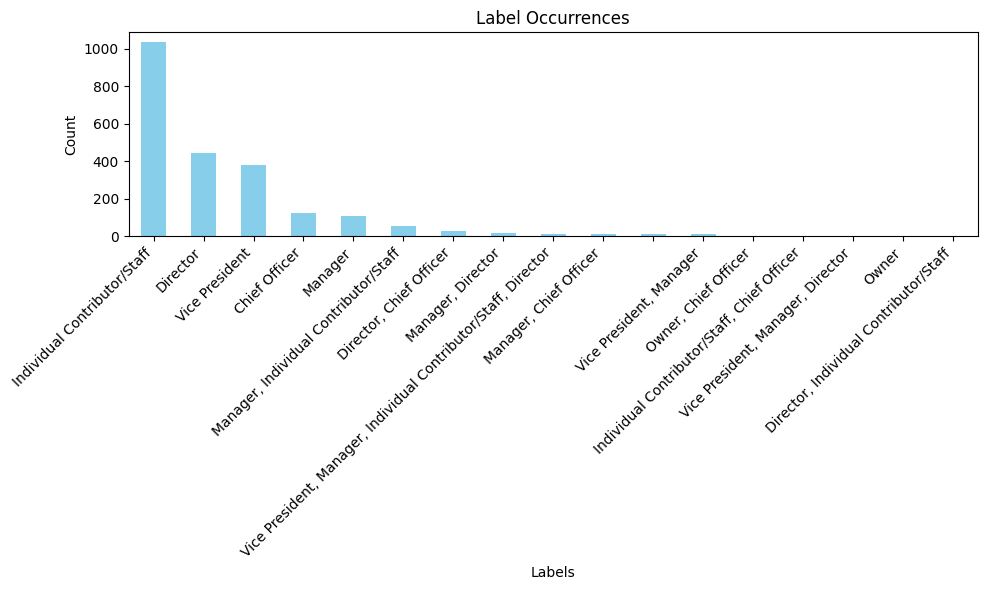

In [ ]:
count_and_visualize_labels(df['String Labels'])

In [ ]:
df['String Labels'].value_counts()

,count
String Labels,
Individual Contributor/Staff,1036
Director,444
Vice President,382
Chief Officer,124
Manager,110
"Manager, Individual Contributor/Staff",54
"Director, Chief Officer",25
"Manager, Director",15
"Vice President, Manager, Individual Contributor/Staff, Director",11


## Analyze Cases with NaN Labels and Handle Them

In [ ]:
#label combination was done ommitting the nan labels, so for such cases there is empty list
blank_labeled_df = df[df['Combined Labels'].apply(lambda x: x == [])]

In [ ]:
blank_labeled_df.shape

(10, 7)

In [ ]:
blank_labeled_df['Title'].values

array(['CINO', 'Ticari Subesi Muduru',
       'Governor, Chair of Board Risk and Audit Committee, Member of Remuneration and Nominations Committees',
       'Former Director, Compensation and Benefits',
       'Release of Information Tech II',
       'Shareholder, Chair of Tax Section',
       'Global People Systems, Processes and Information Manager',
       'Supplier Quality Engineer',
       'RC Environmental and Cyber Specialized Subscription Manager',
       'Senior Independedirector and Chair of the Customer and Communities Network'],
      dtype=object)

In [ ]:
## get the percent of the cases, which don't have label
len(blank_labeled_df)/ len(df)  * 100

0.4464285714285714

In [ ]:
# cause the samples with no labels are ver less and they can add they tend to add noise to train rater adding usefull info
# i decided to drop them( in other cases similarity checking and filling can be done)
df = df[df['Combined Labels'].apply(lambda x: x != [])]

In [ ]:
df.shape

(2230, 7)

In [ ]:
#!pip install -r requirements.txt

## make binarization of combined labels

In [ ]:
import importlib
import data_processing
importlib.reload(data_processing)
from data_processing import  multi_label_binarization
import sklearn
#mlb is multilabel binarizzer of labels
df, classes, mlb = multi_label_binarization(df, 'Combined Labels')
print(classes)

Encoded labels:
 [[0 0 0 0 0 1]
 [0 0 1 1 0 0]
 [1 1 0 0 0 0]
 ...
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]]

Classes:
 ['Chief Officer' 'Director' 'Individual Contributor/Staff' 'Manager'
 'Owner' 'Vice President']
['Chief Officer' 'Director' 'Individual Contributor/Staff' 'Manager'
 'Owner' 'Vice President']


In [ ]:
import pickle
from data_processing import save_mlb_mapping, load_mlb_mapping

# Save the mapping
save_mlb_mapping(mlb)

# Load the mapping
loaded_classes = load_mlb_mapping()
print("\nLoaded classes:", loaded_classes)


Mapping saved to mlb_mapping.pkl
Mapping loaded from mlb_mapping.pkl

Loaded classes: ['Chief Officer' 'Director' 'Individual Contributor/Staff' 'Manager'
 'Owner' 'Vice President']


## clean the text


For text cleaning, I follow these steps:

Handle missing values by skipping or filling them.
Replace separators like semicolons, commas, and slashes with spaces.
Retain relevant characters (e.g., plus and minus signs) while removing unnecessary ones.
Normalize whitespace by collapsing multiple spaces into one and trimming leading or trailing spaces.


In [ ]:

from data_processing import clean_title
df['Title'] = df['Title'].apply(clean_title)

## Split data

In [ ]:
df['Combined Labels'].value_counts()

,count
Combined Labels,
[Individual Contributor/Staff],1036
[Director],444
[Vice President],382
[Chief Officer],124
[Manager],110
"[Manager, Individual Contributor/Staff]",54
"[Director, Chief Officer]",25
"[Manager, Director]",15
"[Manager, Chief Officer]",11


The data is split into groups using stratification. The column 'Encoded Labels' was used for stratification because the analysis showed that, in most cases, the labels are distinct, and only in combined cases does this method apply. For successful stratification, labels with a frequency of one are separated and added to the training set.

This approach helps maintain consistent data distribution across the train, test, and validation groups.
80 percent of data is in train, 10 percent in test group and ~10 percent at val_group

In [ ]:
from data_processing import make_stratify_splitting
train_full_df, test_full_df = make_stratify_splitting(data= df, train_size = 0.8, random_state = 42, stratify_column = 'Encoded Labels')
val_full_df, test_full_df = make_stratify_splitting(data = test_full_df, train_size = 0.5, random_state = 42, stratify_column = 'Encoded Labels')

In [ ]:
# get columns needed for model training
train_data = train_full_df[['Title', 'Encoded Labels']]
test_data = test_full_df[['Title', 'Encoded Labels']]
val_data = val_full_df[['Title', 'Encoded Labels']]

## transformer based model

In [ ]:
training_params = get_json_file('model_training_args.json')
model_name = training_params['model_name']
model_name

'microsoft/deberta-v3-small'

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
from data_processing import create_class_mappings
class2id, id2class = create_class_mappings(classes)
class2id

{'Chief Officer': 0,
 'Director': 1,
 'Individual Contributor/Staff': 2,
 'Manager': 3,
 'Owner': 4,
 'Vice President': 5}

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
num_classes = len(classes)
model = AutoModelForSequenceClassification.from_pretrained(

model_name, num_labels=num_classes,
        id2label=id2class, label2id=class2id,
                    problem_type = "multi_label_classification"
                    )

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Apply tokenization

In [ ]:
from datasets import Dataset
import torch
import data_processing
import importlib
import data_processing
importlib.reload(data_processing)
from data_processing import tokenization_processings

# apply tokenization to separate groups and  modify pandas dataframe to huggingface Dataset
tokenized_train_data = tokenization_processings(train_data, tokenizer)
tokenized_val_data = tokenization_processings(val_data, tokenizer)
tokenized_test_data = tokenization_processings(test_data, tokenizer)

Map:   0%|          | 0/1784 [00:00<?, ? examples/s]

Map:   0%|          | 0/1784 [00:00<?, ? examples/s]

Map:   0%|          | 0/224 [00:00<?, ? examples/s]

Map:   0%|          | 0/224 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

## Define Class weights to handle class inbalance

Cause in data there exists strong class inbalance , class weights are computed that will be used at the loss computation.

In [ ]:
import utils
importlib.reload(utils)
from utils import compute_class_weights

In [ ]:
#cause in multilabel classification labels are computed sepately, weights are computed based on separate classes.
class_weights = compute_class_weights(train_full_df)

## define weighted custom loss

In [ ]:
from train import WeightedLoss, CustomTrainer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)
weighted_loss = WeightedLoss(class_weights)

In [ ]:
from transformers import TrainingArguments
import json
training_args_json= get_json_file('model_training_args.json')
training_args_json.pop('model_name')
training_args_json.pop('train_ratio')

training_args = TrainingArguments(**training_args_json)

In [ ]:
from train import compute_metrics
trainer = CustomTrainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train_data,
   eval_dataset=tokenized_val_data,
   processing_class=tokenizer,
   data_collator=data_collator,
   weighted_loss = weighted_loss,
   compute_metrics=compute_metrics,

)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.187500,0.727299,0.874256,0.634989,0.662162,0.609959
2,0.436200,0.498368,0.904018,0.690647,0.818182,0.597510
3,0.660900,0.496036,0.945685,0.838852,0.896226,0.788382
4,0.330500,0.358908,0.950149,0.853392,0.902778,0.809129
5,0.623000,0.375165,0.959821,0.883117,0.923077,0.846473
6,0.363900,0.372774,0.963542,0.895075,0.924779,0.867220
7,0.154000,0.332572,0.967262,0.903509,0.958140,0.854772
8,0.677200,0.352185,0.967262,0.903930,0.953917,0.858921
9,0.365100,0.353942,0.968006,0.905908,0.958333,0.858921
10,0.154900,0.353312,0.968006,0.905908,0.958333,0.858921


TrainOutput(global_step=1120, training_loss=0.5341733832444463, metrics={'train_runtime': 515.503, 'train_samples_per_second': 34.607, 'train_steps_per_second': 2.173, 'total_flos': 590867787571200.0, 'train_loss': 0.5341733832444463, 'epoch': 10.0})

In [ ]:
trainer.save_model()
tokenizer.save_pretrained(training_args_json.get('output_dir'))

('/content/drive/My Drive/multilabel_classification/huggingface_model/model_artifacts/tokenizer_config.json',
 '/content/drive/My Drive/multilabel_classification/huggingface_model/model_artifacts/special_tokens_map.json',
 '/content/drive/My Drive/multilabel_classification/huggingface_model/model_artifacts/spm.model',
 '/content/drive/My Drive/multilabel_classification/huggingface_model/model_artifacts/added_tokens.json',
 '/content/drive/My Drive/multilabel_classification/huggingface_model/model_artifacts/tokenizer.json')

## inference

In [13]:
#!pip install -r requirements.txt

For inference I computed metrics such as f1, accuracy, precision, recall.
Later I compute metrics based on the each class and improve weights and inbalance handling.

In [5]:
from data_processing import get_splitted_data

In [6]:
from data_processing import load_mlb_mapping
classes = load_mlb_mapping()

Mapping loaded from mlb_mapping.pkl


In [8]:
from inference import get_test_data, get_model, get_tokenizer, compute_inference_metrics
test_data = get_test_data()
tokenizer = get_tokenizer()
model = get_model() #get best model( finetuned huggingface model)

Encoded labels:
 [[0 0 0 0 0 1]
 [0 0 1 1 0 0]
 [1 1 0 0 0 0]
 ...
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]]

Classes:
 ['Chief Officer' 'Director' 'Individual Contributor/Staff' 'Manager'
 'Owner' 'Vice President']


/content/data_processing.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Encoded Labels'] = y_encoded.tolist()
/content/data_processing.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Title'] = df['Title'].apply(clean_title)


In [9]:
compute_inference_metrics(test_data, tokenizer, model, threshold =0.5)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'accuracy': 0.9669669669669669,
 'f1': 0.9013452914798207,
 'precision': 0.9571428571428572,
 'recall': 0.8516949152542372}

## compute metrics based on the separated classes

In [10]:
from inference import divide_data_by_labels

In [11]:
divided_data = divide_data_by_labels(test_data, classes)

In [12]:
import pandas as pd

# Initialize an empty list to store metrics for each label
metrics_per_label = []

# Loop through each label subset in divided_data
for label_idx, label_data in divided_data.items():
    # Compute metrics for the current label subset
    metrics = compute_inference_metrics(label_data, tokenizer, model, threshold=0.5)

    # Append the metrics along with the label index to the list
    metrics_per_label.append({
        'label': label_idx,
        'accuracy': metrics['accuracy'],
        'f1': metrics['f1'],
        'precision': metrics['precision'],
        'recall': metrics['recall'],
    })

# Convert the list of dictionaries into a pandas DataFrame
metrics_df = pd.DataFrame(metrics_per_label)

# Display the DataFrame
print(metrics_df)


    label  accuracy        f1  precision    recall
0       0  0.986842  0.958904   1.000000  0.921053
1       1  0.969697  0.909091   0.909091  0.909091
2       2  0.833333  0.666667   1.000000  0.500000
3       3  0.996764  0.990291   0.990291  0.990291
4       4  0.833333  0.666667   1.000000  0.500000
5       5  1.000000  1.000000   1.000000  1.000000
6       6  0.750000  0.400000   1.000000  0.250000
7       7  0.500000  0.400000   1.000000  0.250000
8       8  0.769231  0.000000   0.000000  0.000000
9       9  0.500000  0.000000   0.000000  0.000000
10     10  0.666667  0.333333   0.500000  0.250000


The metrics on separate classes shows that for some classes the metrics are not good. It is the result of high class inbalance, so it means that in order to improve model performance  the other class weight compute methods must be applied.